*Copyright (C) 2023 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

---

# Satellite Scheduler Tech Demo
This notebook demonstrates the usage of a Lava-Optimization QUBO solver to schedule requests for a constellation of Earth Observation satellites.
The notebook uses the SatelliteSchedulingProblem API to generate synthetic problem instances, convert the problems into QUBO matrices, and then run
the Lava solver to find a satisfactory schedule.

### Scenario Description
Earth Observation satellites orbit the Earth on fixed trajectories with each orbital pass taking between 30 minutes and a few hours. During an orbit,
the satellite can reorient itself to observe different positions on the Earth's surface with its sensors. The ability to reorient is limited by
the satellite's actuators to a maximum rotational rate. For a given satellite to satisfy two sequential observation requests, there must be adequate
time between the requests for the satellite to reorient without exceeding its maximum rotational rate. For simple orbits, the time between requests
is essentially determined by the difference in longitude coordinates of the two requests, divided by the longitudinal velocity of the satellite.

<center><img src="SatSchDemoSchematic.png" width="500"/></center>

### Solution Strategy
The physical constraints of the satellite scheduling problem can be mapped into QUBO by creating a graph corresponding to the vehicles and requests
that are currently being scheduled. Any two requests which cannot be observed by the same vehicle will be connected in the graph by an edge,
indicating a hard constraint between those requests. Using a QUBO solver, we can then find a Maximal Independent Set of the graph, corresponding
to a locally-optimal schedule. This method of scheduling requests for a constellation of satellites can scale up to create schedules for larger
constellations receiving more requests than a conventional scheduling algorithm.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from lava.lib.optimization.apps.scheduler.problems import SatelliteScheduleProblem
from lava.lib.optimization.apps.scheduler.solver import SatelliteScheduler

/Users/shaysnyder/opt/anaconda3/envs/lmao-final/lib/python3.9/site-packages/lava/utils/profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


#### Create a SchedulingProblem object

In [2]:
# scheduling_problem = SatelliteScheduleProblem(num_satellites=5,
#                                               num_requests=100)
# scheduling_problem.view_height = 0.25
# scheduling_problem.turn_rate = 2.0
# scheduling_problem.generate(42)
# scheduling_problem.plot_problem()

#### Create a Scheduler object
Scheduler consumes a SchedulingProblem along with QUBO specific parameters

In [3]:
# scheduler = SatelliteScheduler(scheduling_problem,
#                                qubo_weights=(1, 8),
#                                probe_loihi_exec_time=False)

##### Solve using NetworkX module

In [4]:
# scheduler.solve_with_netx()
# print(f'Scheduled {scheduler.netx_solution.shape[0]} Requests.')

##### Solve using Lava QUBO Solver on Loihi 2

In [5]:
# scheduler.qubo_hyperparams = ({"temperature": 1},
#                               True)
# scheduler.lava_backend = "CPU"
# scheduler.solve_with_lava_qubo(timeout=1000)

In [6]:
# scheduler.plot_solutions()

In [7]:
# scheduler.lava_solution.shape[0]

In [8]:
def run_ssp(arg1: int, arg2: int, arg3: int, arg4: int = 1, arg5: int = 8, num_repeats: int = 1, num_requests: int = 1000, plotting: bool = False) -> float:
    view_height = float(arg1)
    turn_rate = float(arg2)
    num_satellites = int(arg3)
    qubo_weight_0 = float(arg4)
    qubo_weight_1 = qubo_weight_0 * float(arg5)

    request_logs = []
    for repeat_idx in range(num_repeats):
        scheduling_problem = SatelliteScheduleProblem(
            num_satellites=num_satellites,
            num_requests=num_requests
        )
        scheduling_problem.view_height = view_height
        scheduling_problem.turn_rate = turn_rate
        scheduling_problem.generate(seed=repeat_idx)

        scheduler = SatelliteScheduler(
            scheduling_problem,
            qubo_weights=(qubo_weight_0, qubo_weight_1),
        )

        scheduler.qubo_hyperparams = ({"temperature": 1}, True)
        scheduler.lava_backend = "CPU"
        scheduler.solve_with_lava_qubo(timeout=250)

        num_satisfies = scheduler.lava_solution.shape[0]
        print(num_satisfies)
        request_logs.append(num_satisfies)


    avg_requests = np.mean(request_logs)
    avg_requests = -1 * avg_requests
    return avg_requests
        

In [9]:
results = run_ssp(1, 1, 2, 1, 2.1)

76


In [10]:
results

-76.0

In [11]:
# -------------
# Grid Search
# -------------


In [12]:
# ------
# BO
# ------
from skopt import Space
from skopt.space import Real, Integer, Categorical
import time

search_space_int = Space([
    Categorical([0.25, 0.50, 0.75, 1.0, 1.25, 1.5],  name="view_height"),
    Categorical([1.0, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3.0],  name="turn_rate"),
    Integer(2, 6,   name="number of satellites"),
])

# search_space_int = Space([
#     Categorical([0.01, 0.02],  name="view_height"),
#     Categorical([1.0, 1.25],  name="turn_rate"),
#     Integer(2, 3,   name="number of satellites"),
#     Integer(1, 2,     name="qubo_weight_0"),
#     Integer(3, 4,   name="qubo_weight_1_scaler"),
# ])

num_initial_points = 50
num_iterations = 270
optimizer_class = "grid-cpu"

from omegaconf import DictConfig
from lmao.solver import BOSolver

optimizer_config = DictConfig({
    "num_initial_points": num_initial_points,
    "max_iterations": num_iterations,
    "num_processes": 1,
    "num_repeats": 1,
    "optimizer_class": optimizer_class,
    "optimizer": {
        "num_initial_points": num_initial_points,
    },
    "seed": 10,
})

solver = BOSolver(optimizer_config)

start_time = time.time()
result = solver.solve(
    run_ssp,
    use_lp=False,
    search_space=search_space_int,
)
total_time = time.time() - start_time
print(f"Total Time: {total_time}")

212
time step:  0
max iterations:  270
new data:  [   1.    3.    6. -212.]
215
time step:  1
max iterations:  270
new data:  [   1.    3.    5. -215.]
186
time step:  2
max iterations:  270
new data:  [   1.    3.    4. -186.]
151
time step:  3
max iterations:  270
new data:  [   1.    3.    3. -151.]
91
time step:  4
max iterations:  270
new data:  [  1.   3.   2. -91.]
199
time step:  5
max iterations:  270
new data:  [   1.    2.    6. -199.]
191
time step:  6
max iterations:  270
new data:  [   1.    2.    5. -191.]
163
time step:  7
max iterations:  270
new data:  [   1.    2.    4. -163.]
122
time step:  8
max iterations:  270
new data:  [   1.    2.    3. -122.]
65
time step:  9
max iterations:  270
new data:  [  1.   2.   2. -65.]
199
time step:  10
max iterations:  270
new data:  [   1.    2.    6. -199.]
191
time step:  11
max iterations:  270
new data:  [   1.    2.    5. -191.]
163
time step:  12
max iterations:  270
new data:  [   1.    2.    4. -163.]
122
time step:  13


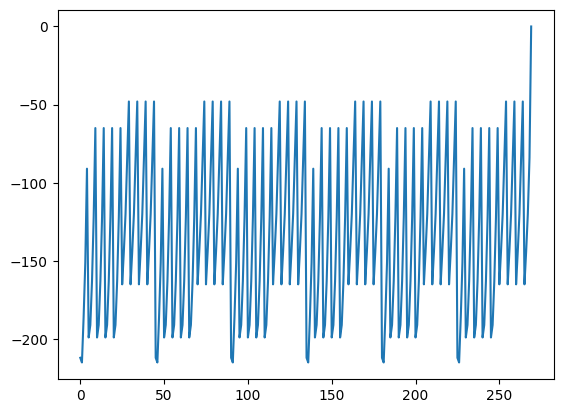

In [13]:
plt.plot(result["y_log"])

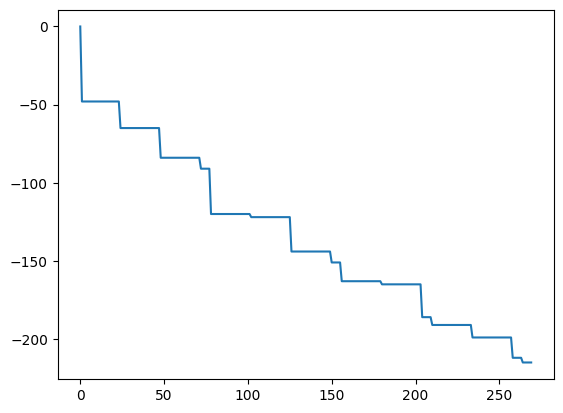

In [14]:
plt.plot(sorted(result["y_log"], reverse=True))

In [15]:
len(result["y_log"])

270